In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [401]:
original = pd.read_csv('Round_3_results.csv', delimiter = ',')

In [402]:
# Add a computed column combinging working set + swap
original['Memory Usage (MB)'] = original['Working Set (MB)'] + original['Swap (MB)']

In [403]:
# Reorder columns for more clarity
#
# Scenario, Memory Limit, CPU Limit, and RPS are inputs
# Mean Latency, Working Set and CPU Utilization are outputs (things that were measured)
#
# The rest of the columns are here for validation/context
original = original[[
    'Scenario', 
    'Memory Limit (MB)', 
    'CPU Limit',
    'RPS',
    'Latency 75% (ms)',
    'Latency 90% (ms)',
    'Working Set (MB)',
    'Swap (MB)',
    'Memory Usage (MB)',
    'CPU Utilization %', 
    'Max CPU Utilization %',
    'Completed Requests',
    'Completed Requests (%)']]

In [404]:
# define our parameters
scenarios = original['Scenario'].unique()

# examples
# plt.rcParams['axes.prop_cycle']
# manually managing colors because the default set
# only has 10
scenario_colors = {
    'dotnet-controllers': '#1f77b4',
    'dotnet-route-to-code': '#17becf',
    'go-fasthttp': '#2ca02c',
    'go-stdlib': '#d62728',
    'java-quarkus-graal': '#9467bd',
    'java-quarkus-jvm': '#8c564b',
    'java-springboot': '#e377c2',
    'java-springbootwebflux': '#7f7f7f',
    'node-express': '#ff7f0e',
    'python-aiohttp': '#bcbd22',
    'python-flask': '#2e2829',
}

rpses = original['RPS'].unique()
rpses.sort()

In [433]:
# exclude results that don't meet our thresholds for "working well"
#
# this is defined right now as completing > 90% of the expected amount of throughput
# and we're excluding results with really high latency to avoid wrecking the visualization
unfiltered = original
table = original[(original['Completed Requests (%)'] >= 90) & (original['Latency 90% (ms)'] <= 500)]
print(f'Unfiltered rows: {len(unfiltered)} Filtered Rows: {len(table)})')

Unfiltered rows: 594 Filtered Rows: 215)


In [406]:
def make_plot(df, metric, rps):
    fig, ax = plt.subplots()
    ax.set_title(f'{metric} by CPU Limit and Memory Limit with RPS == {rps}')
    ax.set_ylabel(f'{metric}')
    
    width = 0.80
    
    by_combination = df.groupby(['CPU Limit', 'Memory Limit (MB)'])
    x_pos = np.arange(len(by_combination.groups))
    bar_width = width / scenarios.size

    for i, scenario in enumerate(scenarios):
        x_values = []
        for keys, frame in by_combination:
            memory_limit = keys[1]
            cpu_limit = keys[0]
            filtered = frame[(frame['RPS'] == rps)  & (frame['Scenario'] == scenario)]
            value = filtered[metric].values[0] if filtered.values.any() else 0
            x_values.append(value)
    
        offset = (i - (scenarios.size / 2 )) * bar_width
        ax.bar(np.subtract(x_pos, offset), x_values, width / scenarios.size, align='center', label=scenario, color=scenario_colors[scenario])

    x_labels = []
    i = 0
    for keys, frame in by_combination:
        x_labels.append(f'{keys[1]}MB x {keys[0]} CPU')

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels)
    ax.legend()
    fig.set_size_inches(20, 8)

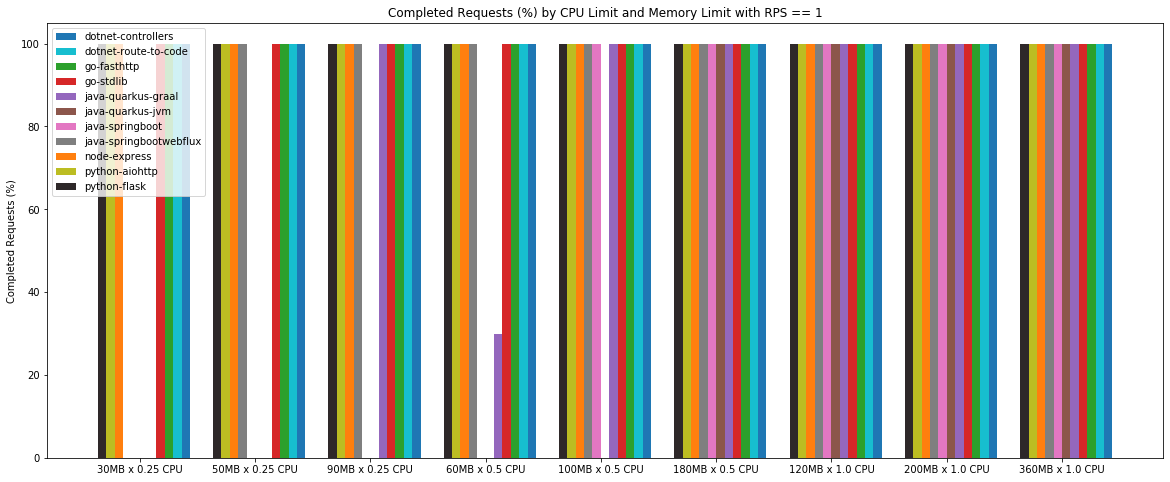

In [407]:
make_plot(unfiltered, 'Completed Requests (%)', 1)

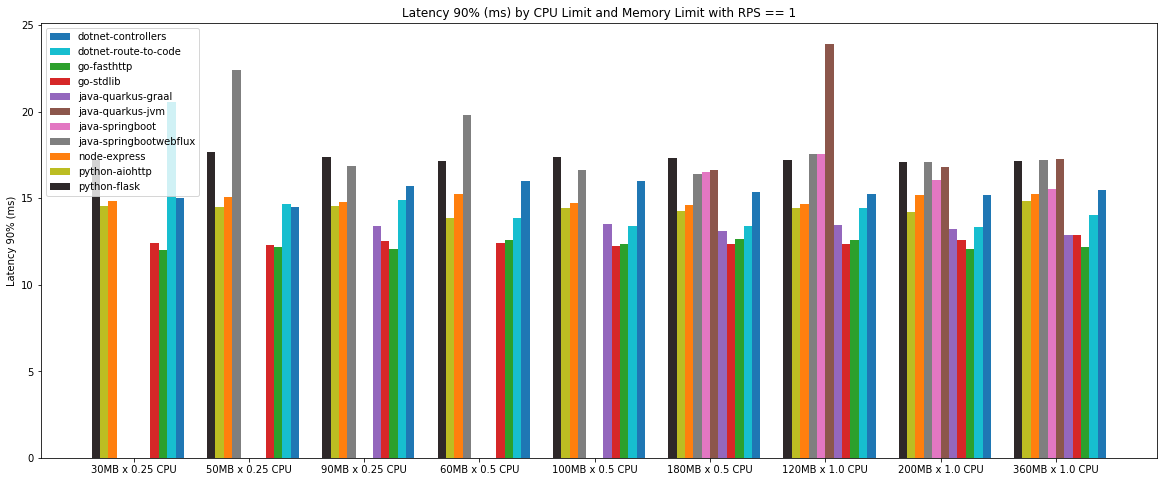

In [408]:
make_plot(table, 'Latency 90% (ms)', 1)

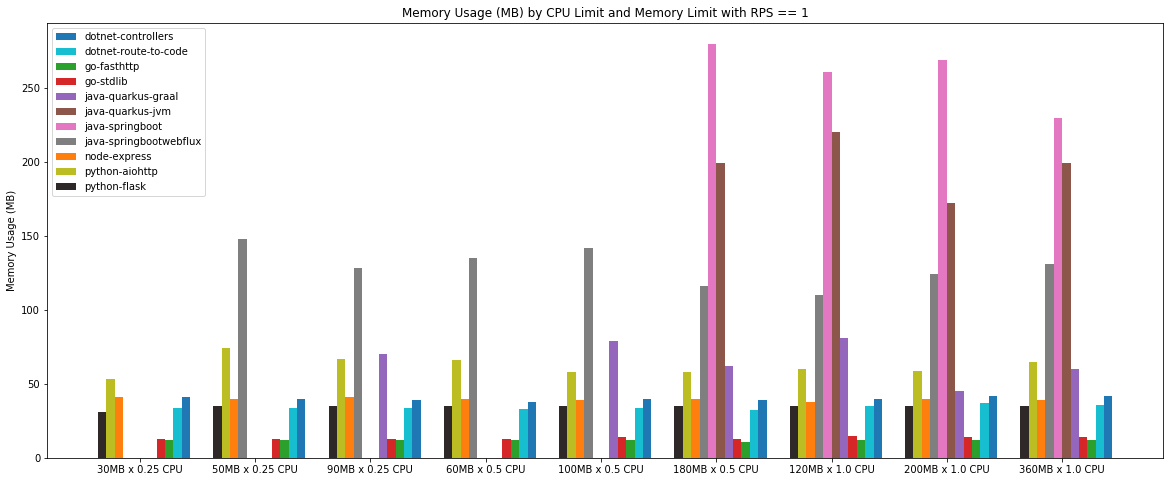

In [409]:
make_plot(table, 'Memory Usage (MB)', 1)

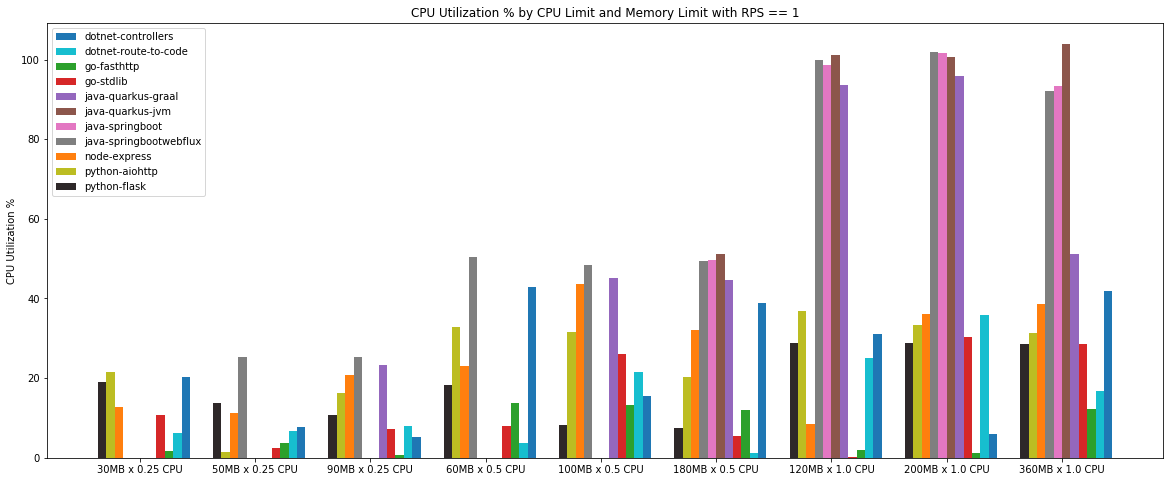

In [410]:
make_plot(table, 'CPU Utilization %', 1)

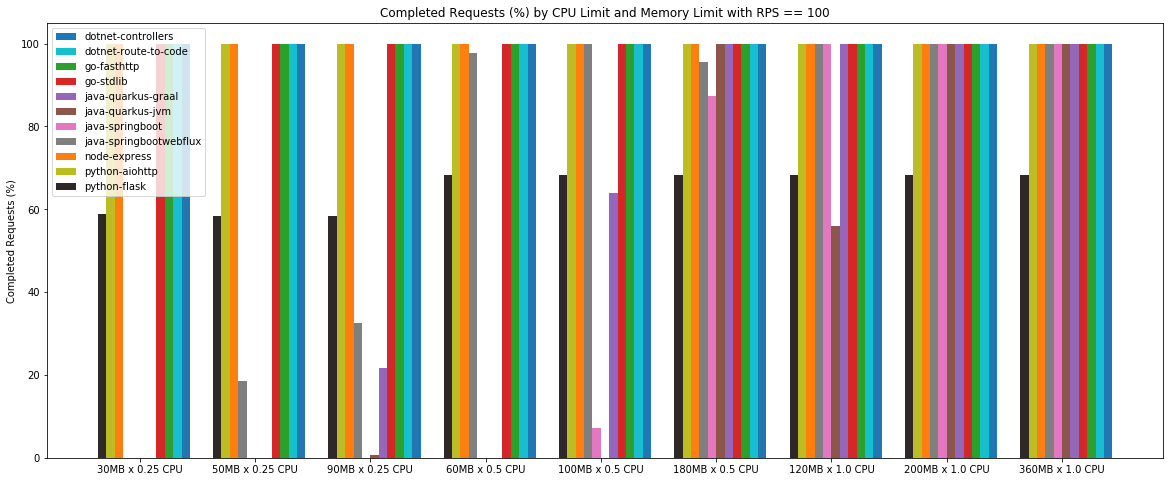

In [411]:
make_plot(unfiltered, 'Completed Requests (%)', 100)

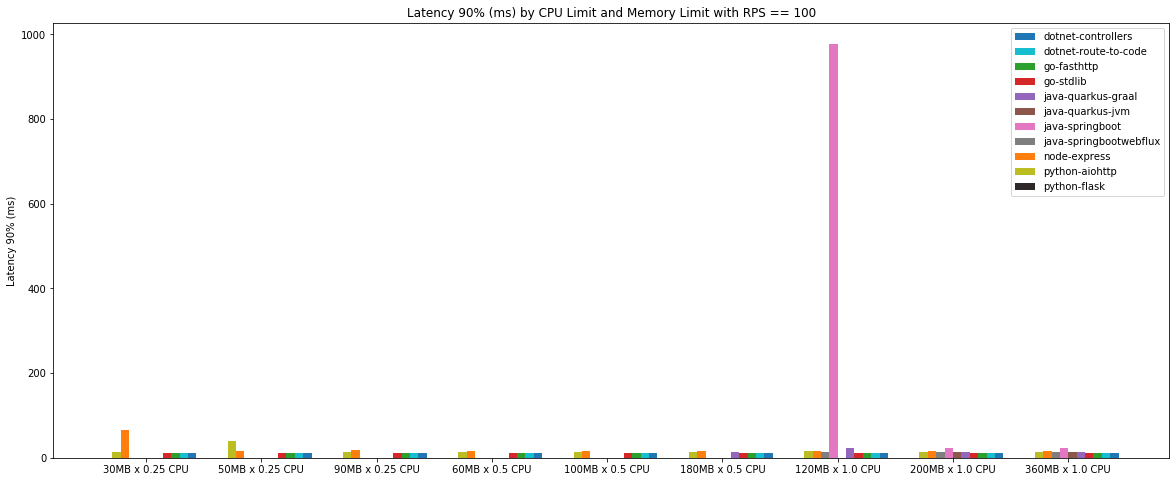

In [412]:
make_plot(table, 'Latency 90% (ms)', 100)

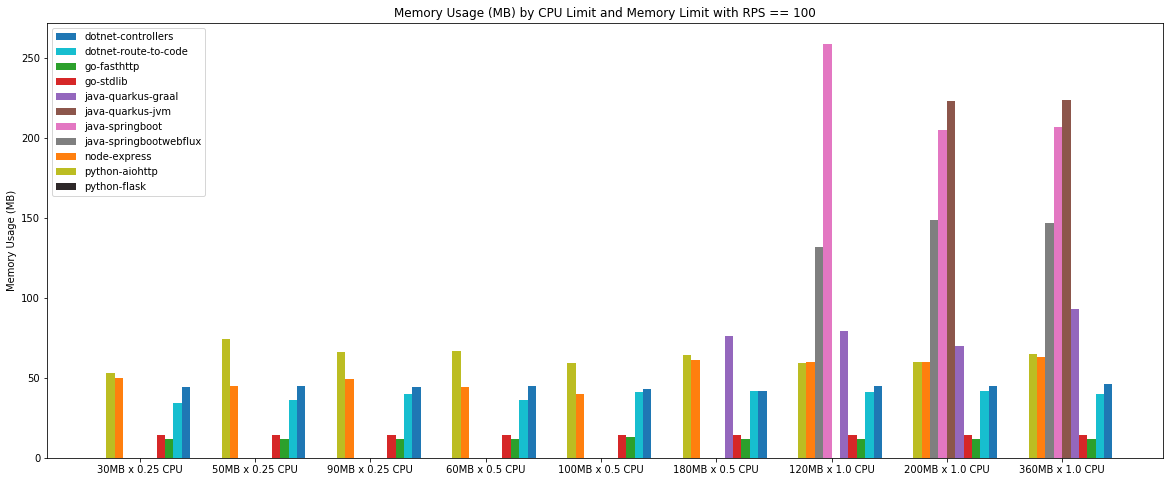

In [413]:
make_plot(table, 'Memory Usage (MB)', 100)

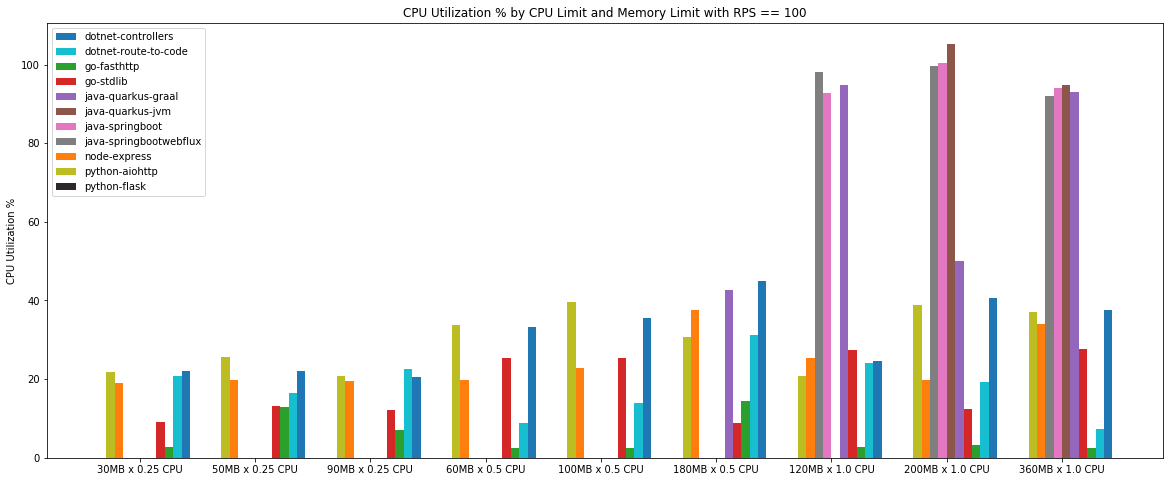

In [414]:
make_plot(table, 'CPU Utilization %', 100)

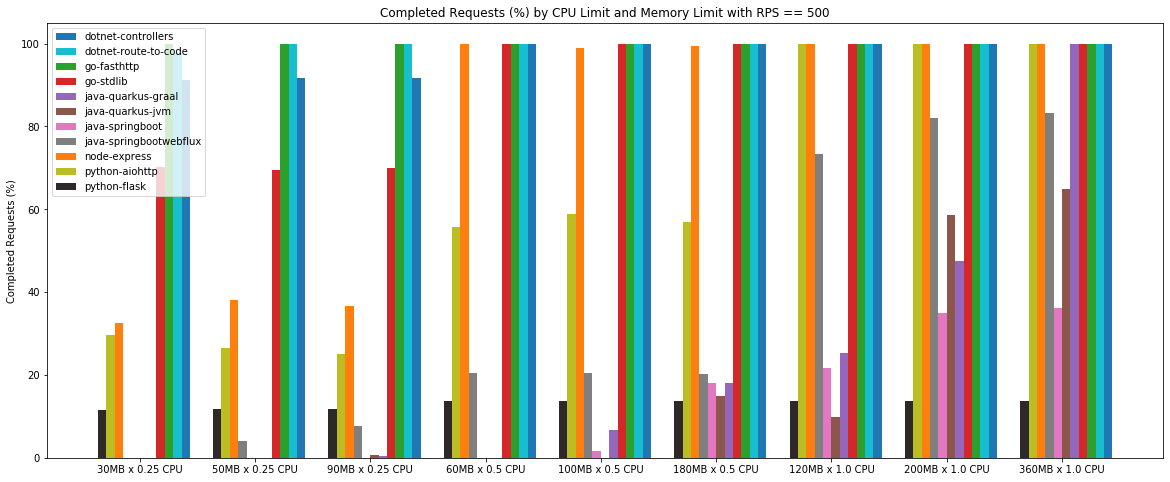

In [415]:
make_plot(unfiltered, 'Completed Requests (%)', 500)

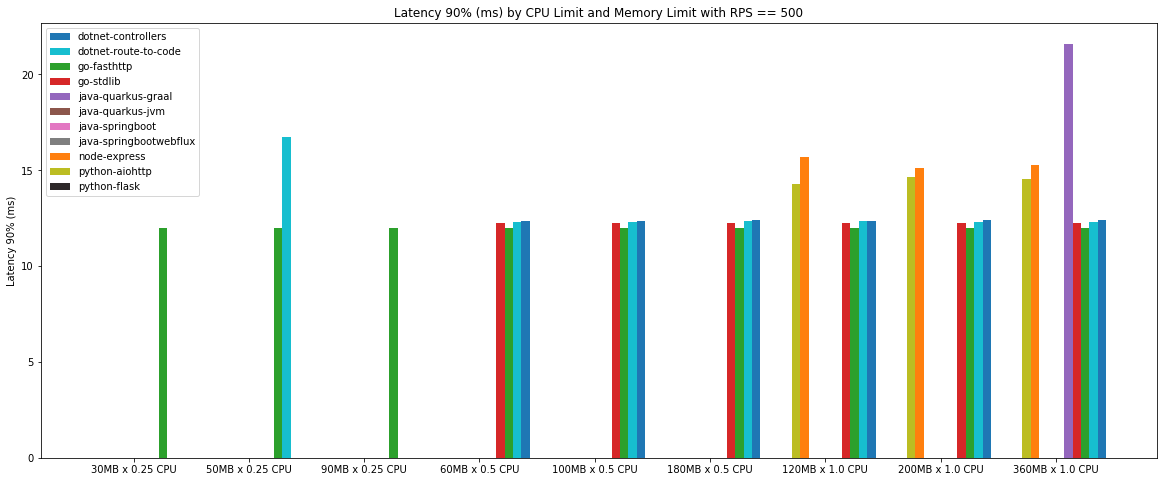

In [416]:
make_plot(table, 'Latency 90% (ms)', 500)

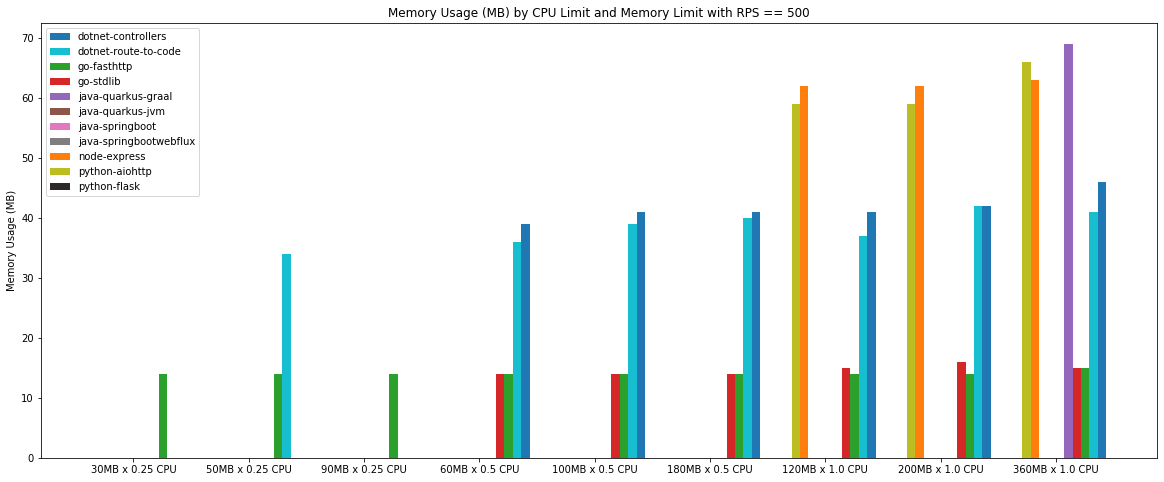

In [417]:
make_plot(table, 'Memory Usage (MB)', 500)

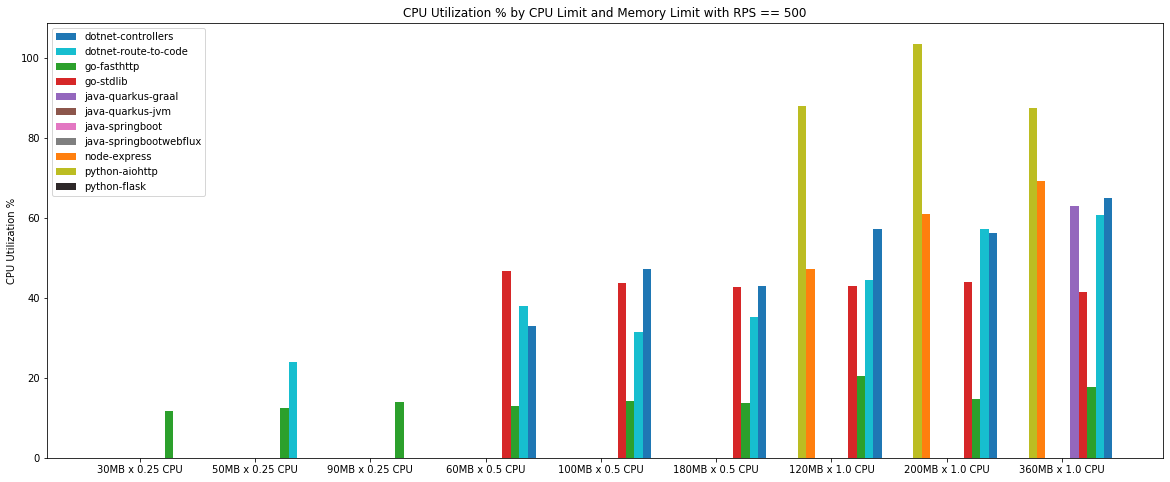

In [418]:
make_plot(table, 'CPU Utilization %', 500)

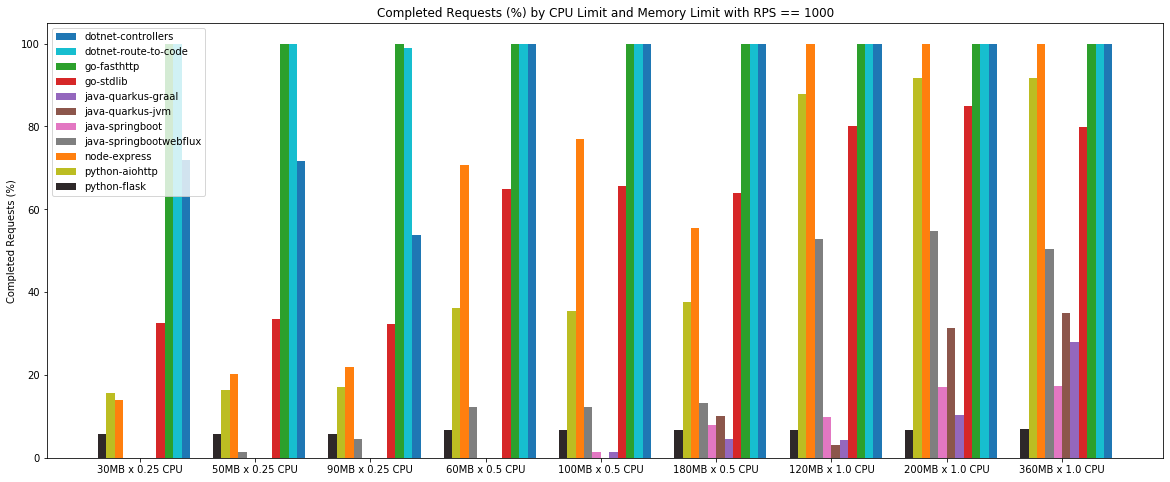

In [419]:
make_plot(unfiltered, 'Completed Requests (%)', 1000)

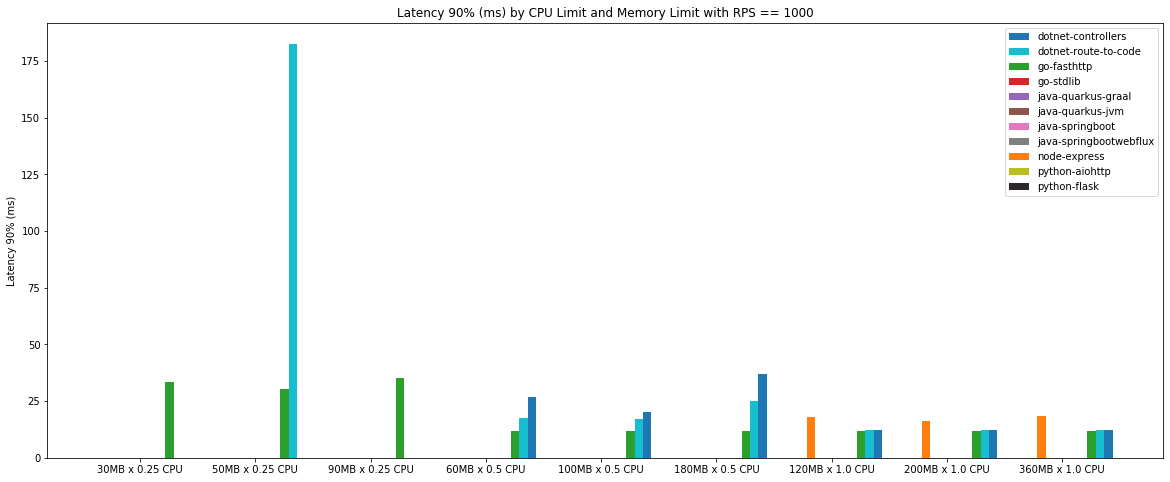

In [420]:
make_plot(table, 'Latency 90% (ms)', 1000)

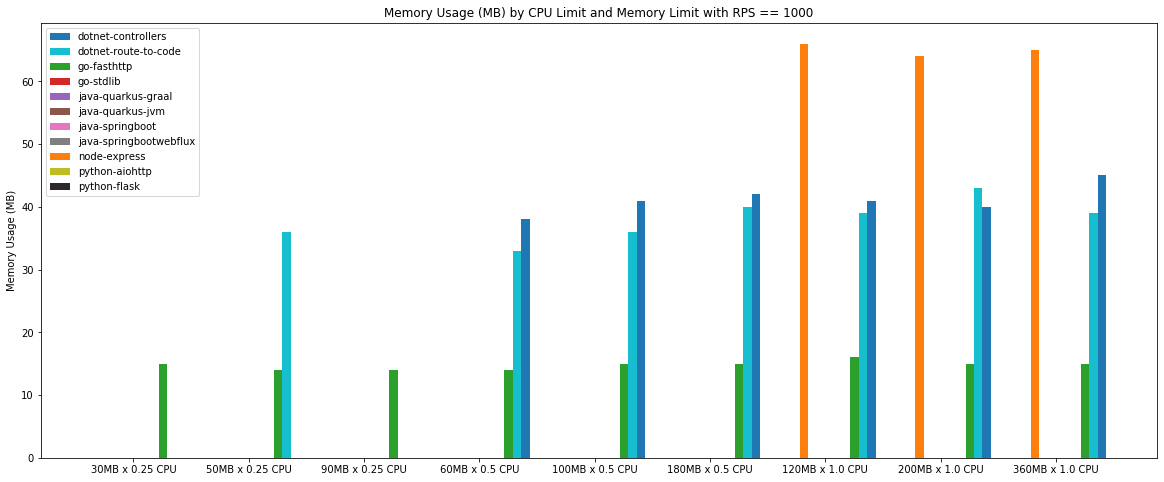

In [421]:
make_plot(table, 'Memory Usage (MB)', 1000)

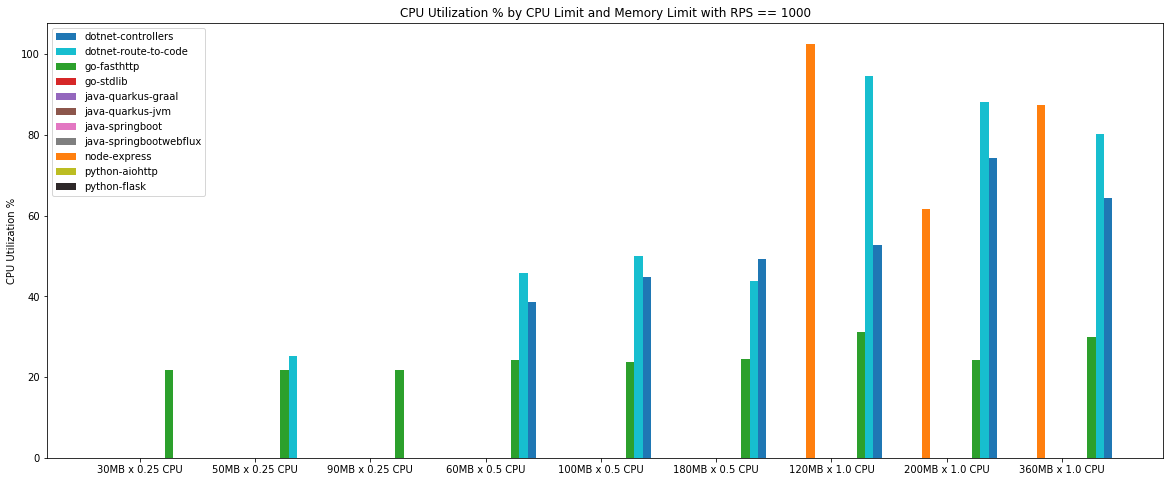

In [422]:
make_plot(table, 'CPU Utilization %', 1000)

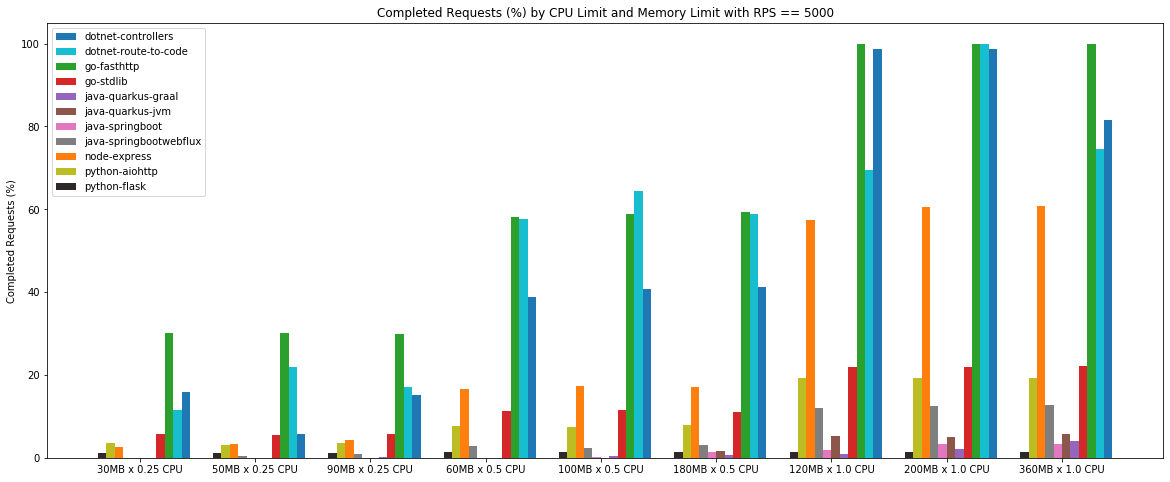

In [423]:
make_plot(unfiltered, 'Completed Requests (%)', 5000)

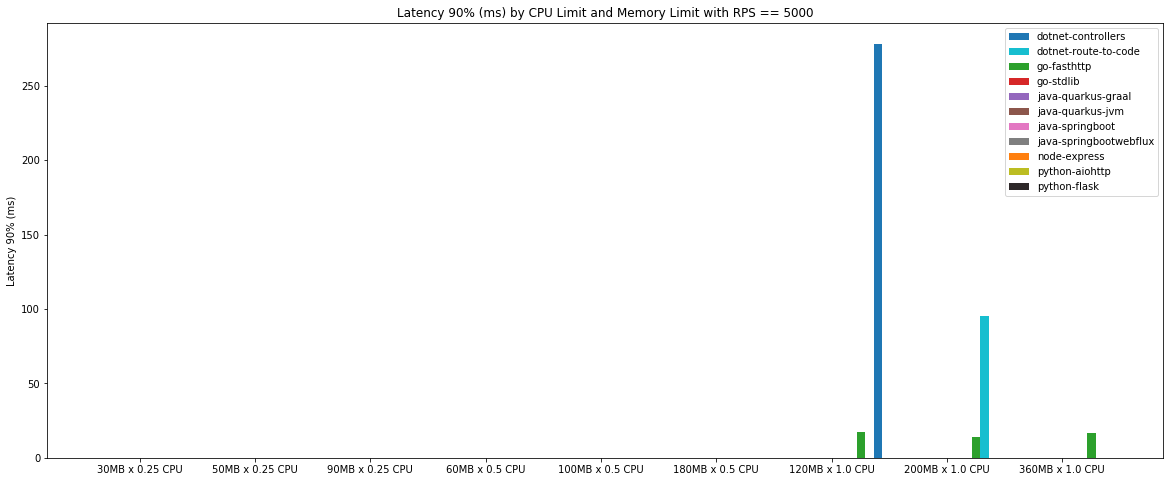

In [424]:
make_plot(table, 'Latency 90% (ms)', 5000)

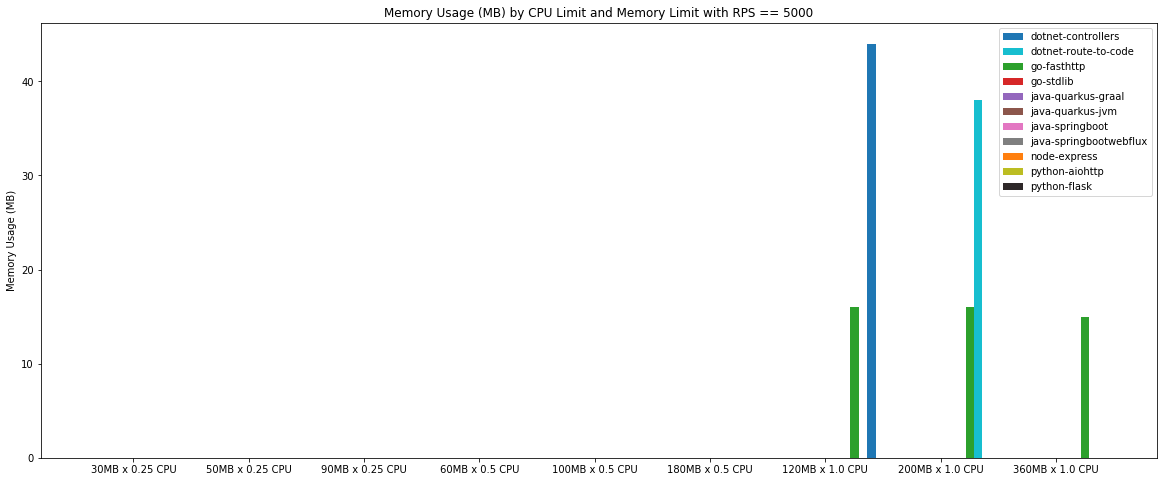

In [425]:
make_plot(table, 'Memory Usage (MB)', 5000)

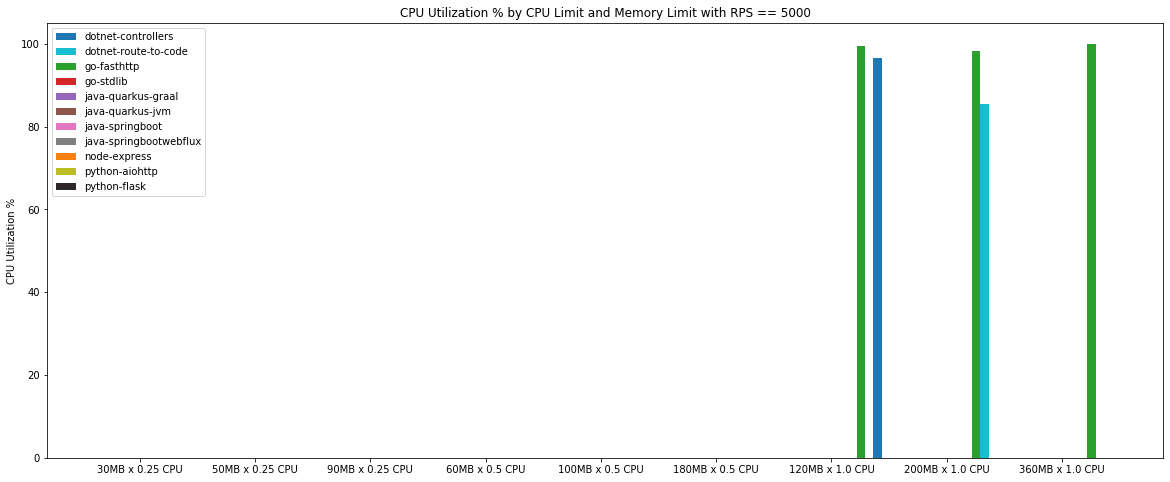

In [426]:
make_plot(table, 'CPU Utilization %', 5000)

In [427]:
def make_showdown(df, metric, showdown_scenarios):
    fig, ax = plt.subplots()
    ax.set_title(f'Comparison of {metric} by CPU Limit and Memory Limit for {", ".join(showdown_scenarios)}')
    ax.set_ylabel(f'{metric}')
    
    width = 0.80
    
    by_combination = df.groupby(['CPU Limit', 'Memory Limit (MB)'])
    x_pos = np.arange(len(by_combination.groups))
    bar_width = width / (len(showdown_scenarios) * len(rpses))

    i = 0
    for rps in rpses[::-1]:
        for scenario in showdown_scenarios:
            x_values = []
            for keys, frame in by_combination:
                filtered = frame[(frame['RPS'] == rps)  & (frame['Scenario'] == scenario)]
                value = filtered[metric].values[0] if filtered.values.any() else 0
                x_values.append(value)

            label = f'{scenario} - {rps}'
            offset = (i - (scenarios.size / 2 )) * bar_width
            bar = ax.bar(np.subtract(x_pos, offset), x_values, width / scenarios.size, align='center', label=label, color=scenario_colors[scenario])
            i += 1
            
    x_labels = []
    for keys, frame in by_combination:
        x_labels.append(f'{keys[1]}MB x {keys[0]} CPU')

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels)
    ax.legend()
    fig.set_size_inches(20, 8)

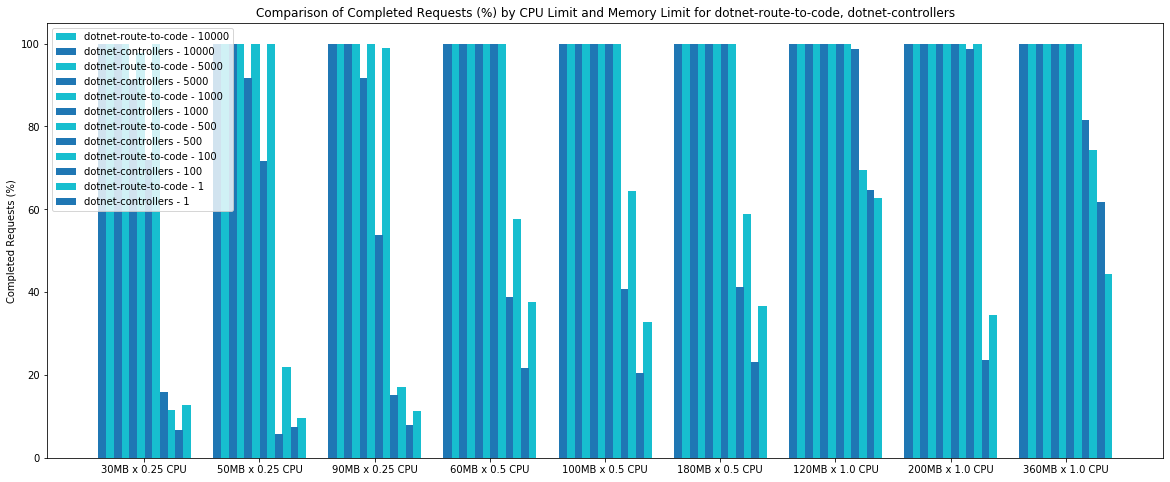

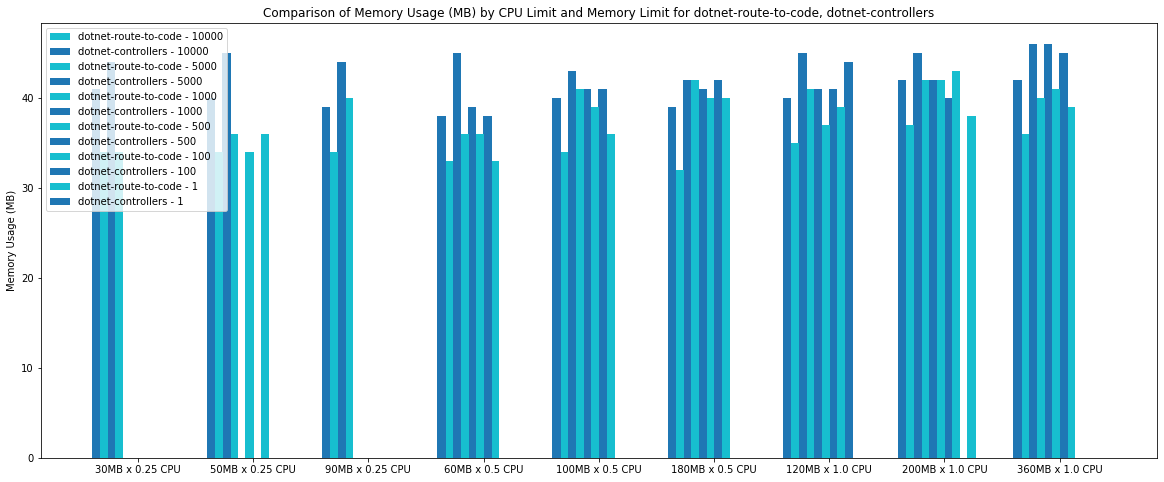

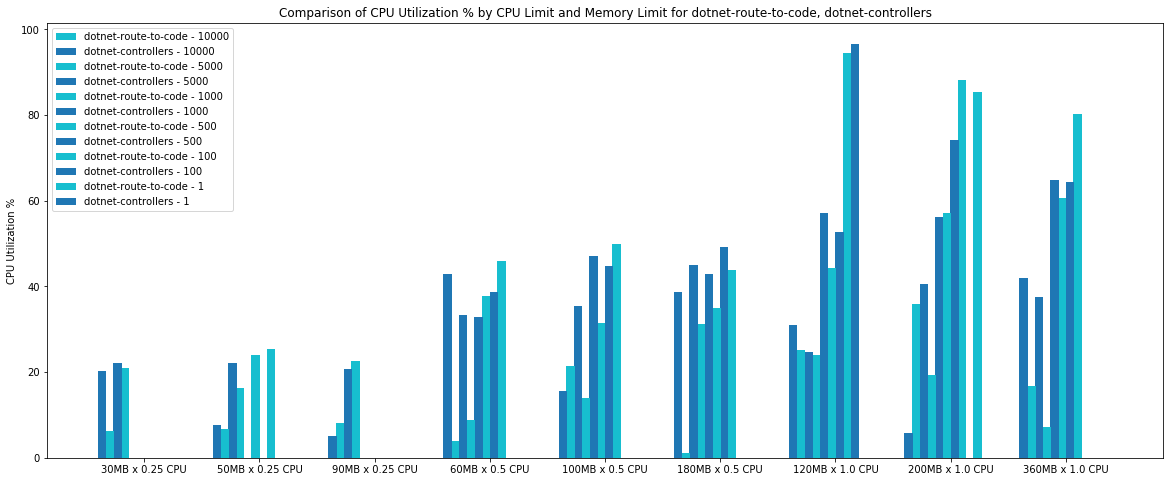

In [428]:
make_showdown(unfiltered, 'Completed Requests (%)', ['dotnet-route-to-code', 'dotnet-controllers'])
make_showdown(table, 'Memory Usage (MB)', ['dotnet-route-to-code', 'dotnet-controllers'])
make_showdown(table, 'CPU Utilization %', ['dotnet-route-to-code', 'dotnet-controllers'])

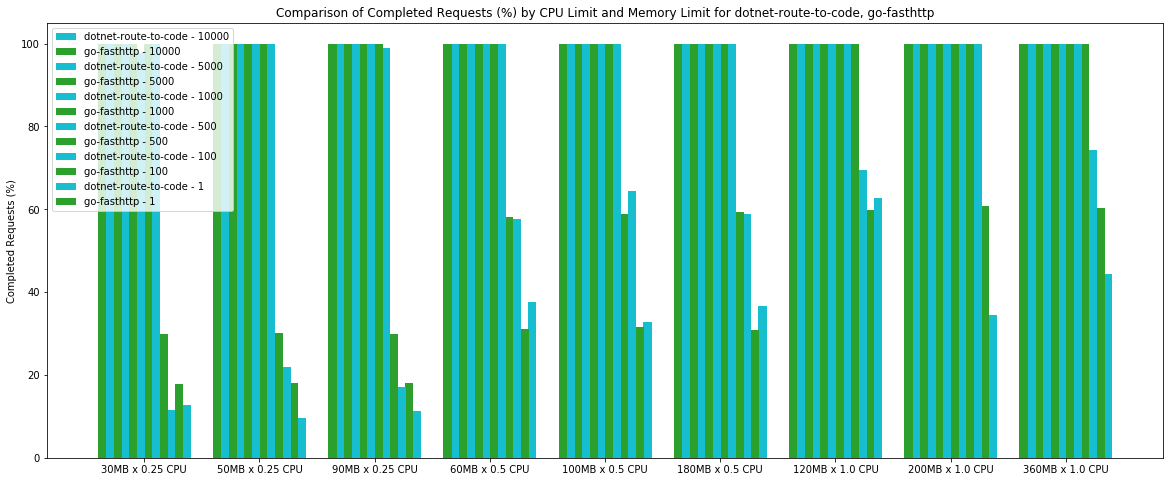

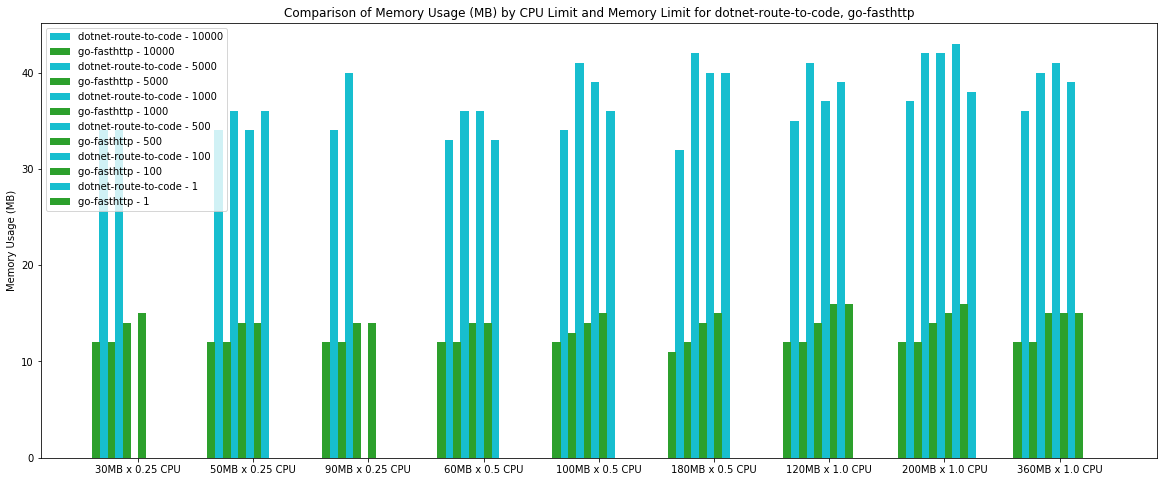

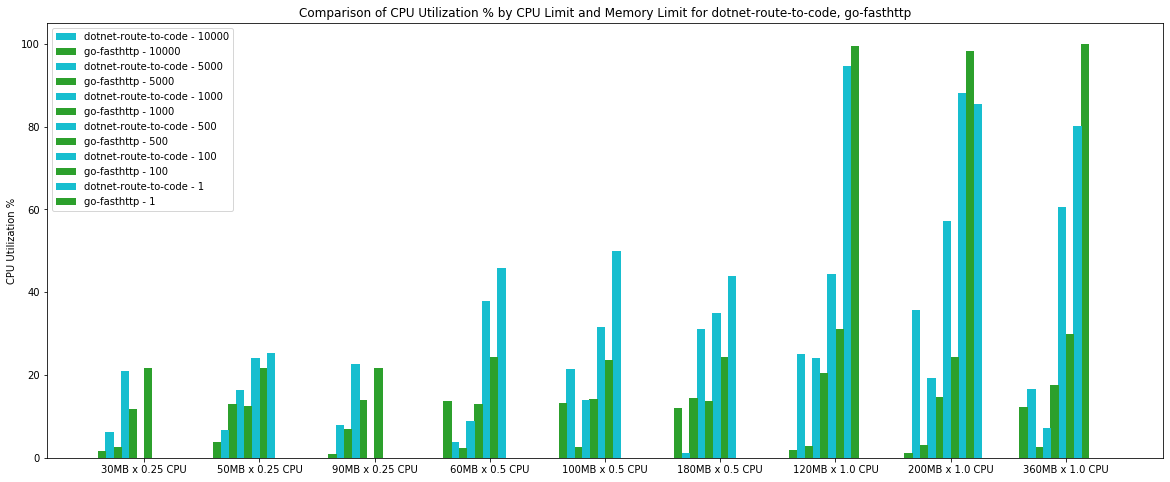

In [429]:
make_showdown(unfiltered, 'Completed Requests (%)', ['dotnet-route-to-code', 'go-fasthttp'])
make_showdown(table, 'Memory Usage (MB)', ['dotnet-route-to-code', 'go-fasthttp'])
make_showdown(table, 'CPU Utilization %', ['dotnet-route-to-code', 'go-fasthttp'])

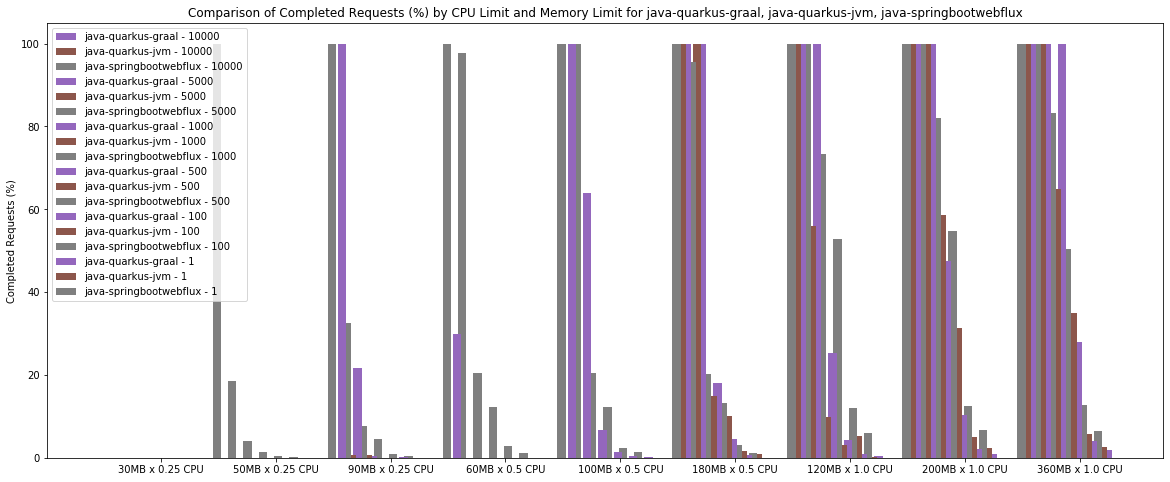

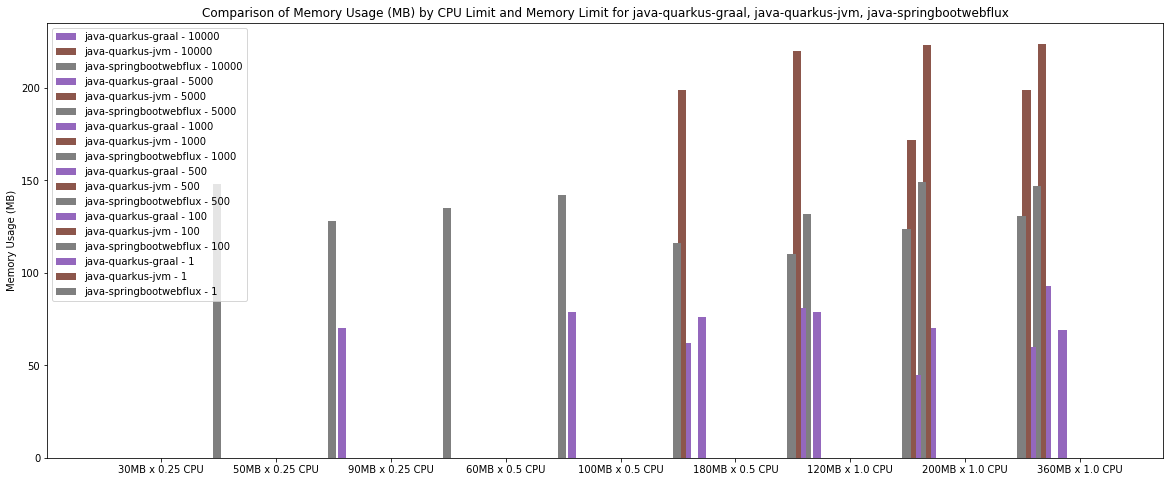

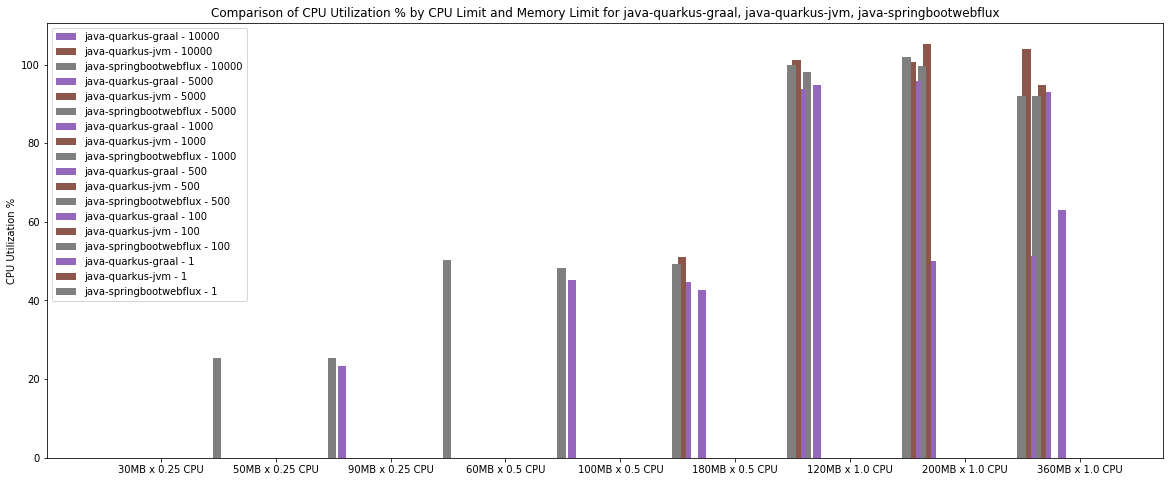

In [430]:
make_showdown(unfiltered, 'Completed Requests (%)', ['java-quarkus-graal', 'java-quarkus-jvm', 'java-springbootwebflux'])
make_showdown(table, 'Memory Usage (MB)', ['java-quarkus-graal', 'java-quarkus-jvm', 'java-springbootwebflux'])
make_showdown(table, 'CPU Utilization %', ['java-quarkus-graal', 'java-quarkus-jvm', 'java-springbootwebflux'])

In [431]:
def make_heatmap(df, scenario):
    memory_limits = df['Memory Limit (MB)'].unique()
    cpu_limits = df['CPU Limit'].unique()
    
    by_combination = df.groupby(['CPU Limit', 'Memory Limit (MB)'])

    results = np.zeros((rpses.size, len(by_combination)), dtype=float)
    
    for i, rps in enumerate(rpses):
        j = 0
        for keys, frame in by_combination:
            cpu_limit = keys[0]
            memory_limit = keys[1]
            filtered = frame[
                (frame['Scenario'] == scenario) &
                (frame['RPS'] == rps) & 
                (frame['Memory Limit (MB)'] == memory_limit) & 
                (frame['CPU Limit'] == cpu_limit)]
            value = filtered['Completed Requests (%)'].values[0] if filtered.values.any() else 0
            results[i, j] = min(value, 100)
            j += 1
                
    fig, ax = plt.subplots()
    ax.set_title(f'Heatmap of completed request % for {scenario}')
    ax.set_xlabel('CPU Limit x Memory Limit (MB)')
    ax.set_ylabel('RPS')
    x_pos = np.arange(cpu_limits.size * memory_limits.size)
    x_labels = []
    for keys, frame in by_combination:
        x_labels.append(f'{keys[1]}MB x {keys[0]} CPU')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels)
    
    y_pos = np.arange(rpses.size)
    y_labels = rpses
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels)
    
    fig.set_size_inches(16, 10)
    image = ax.imshow(results, interpolation=None, cmap='RdYlBu', vmax=100, vmin=0)
    fig.colorbar(image, ax=ax)
    return results

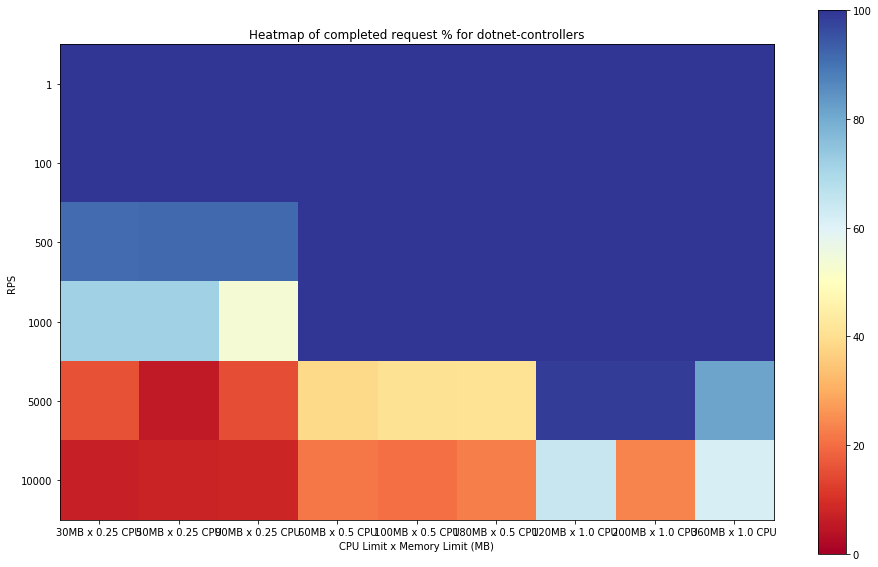

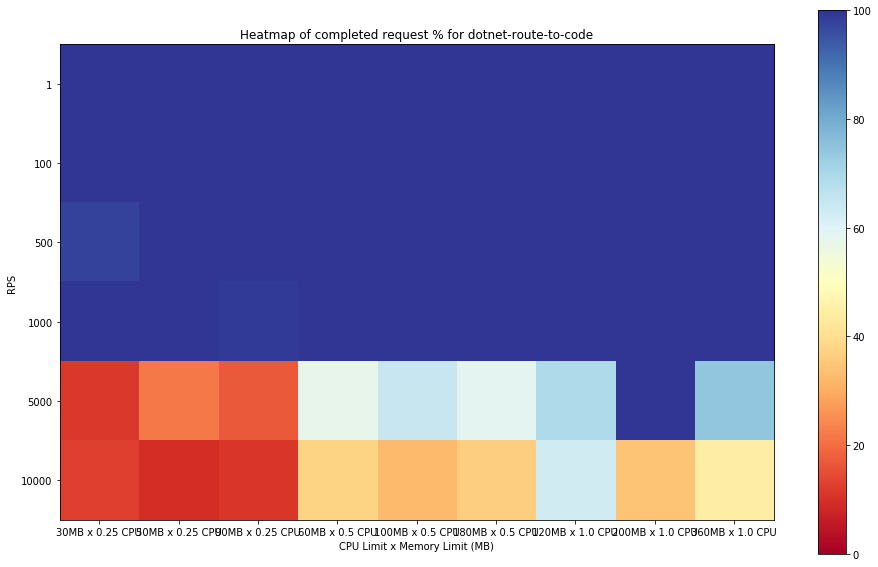

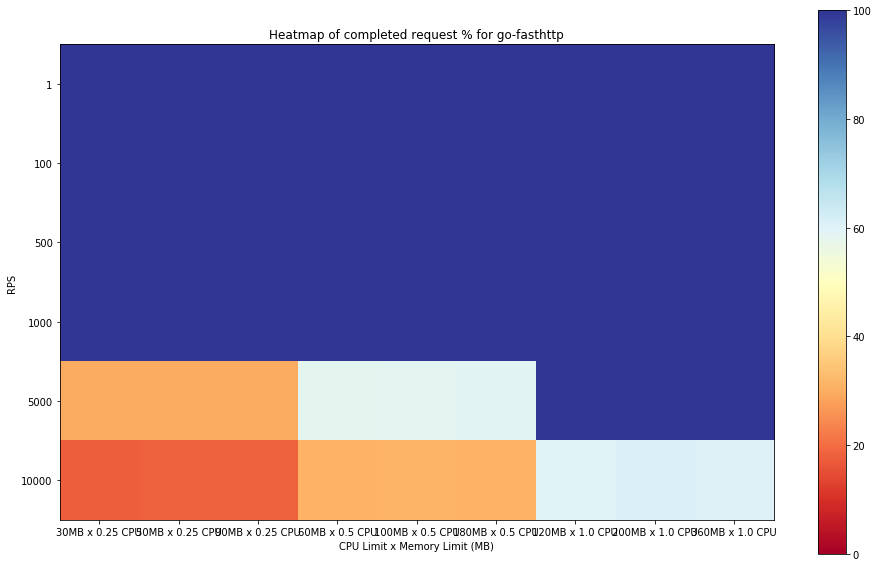

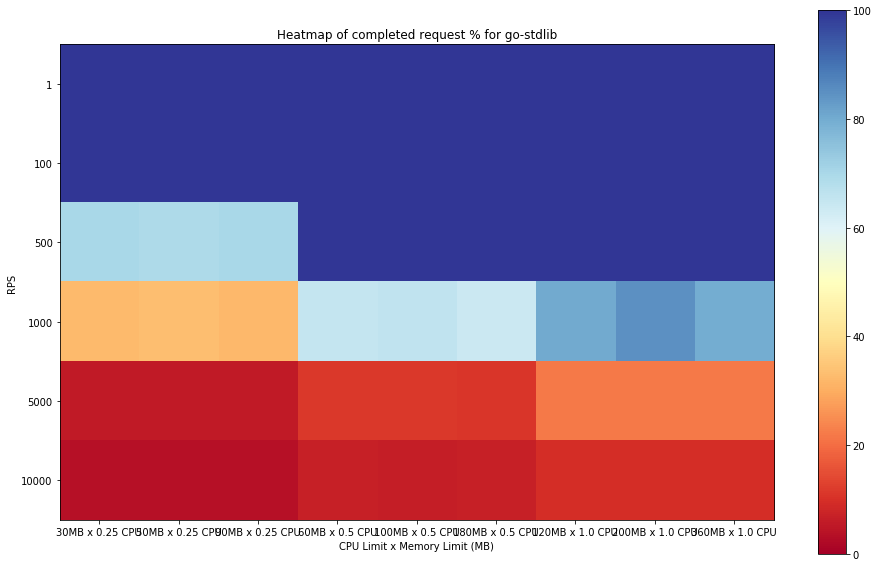

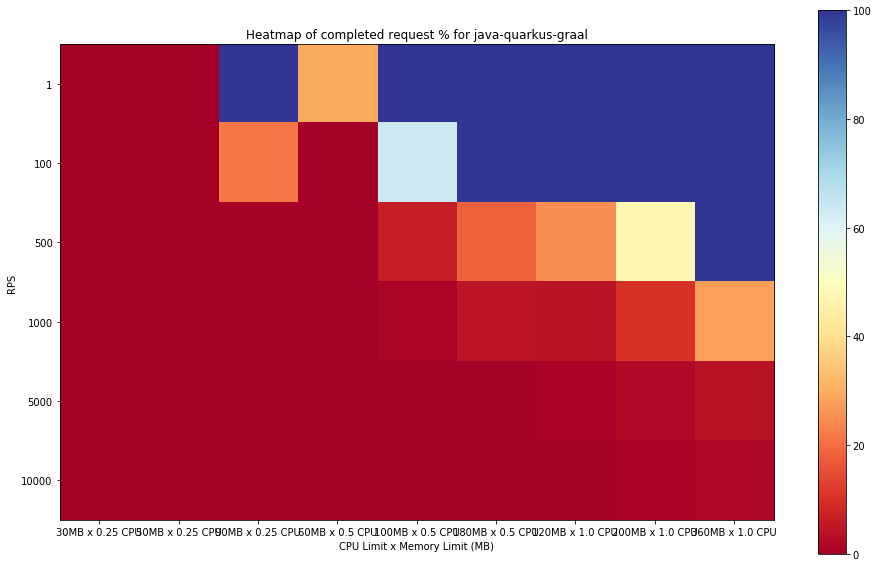

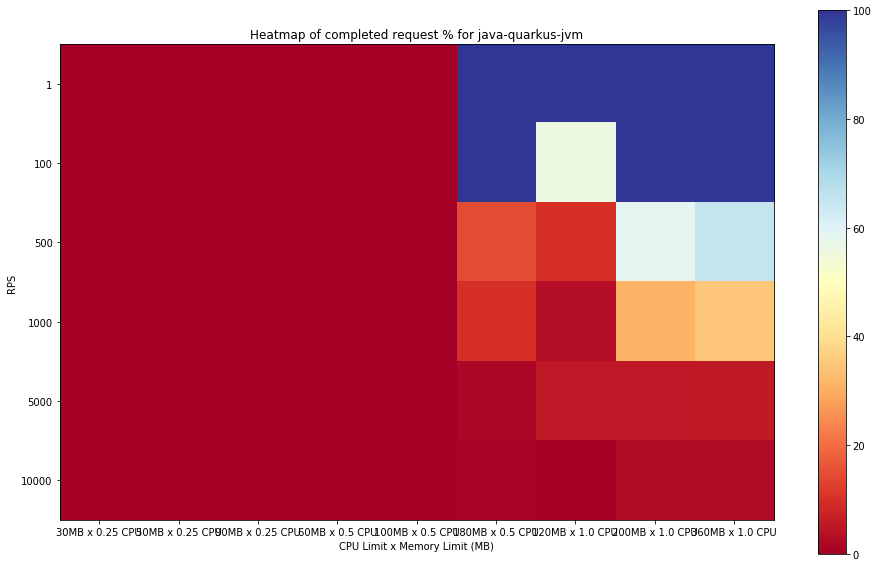

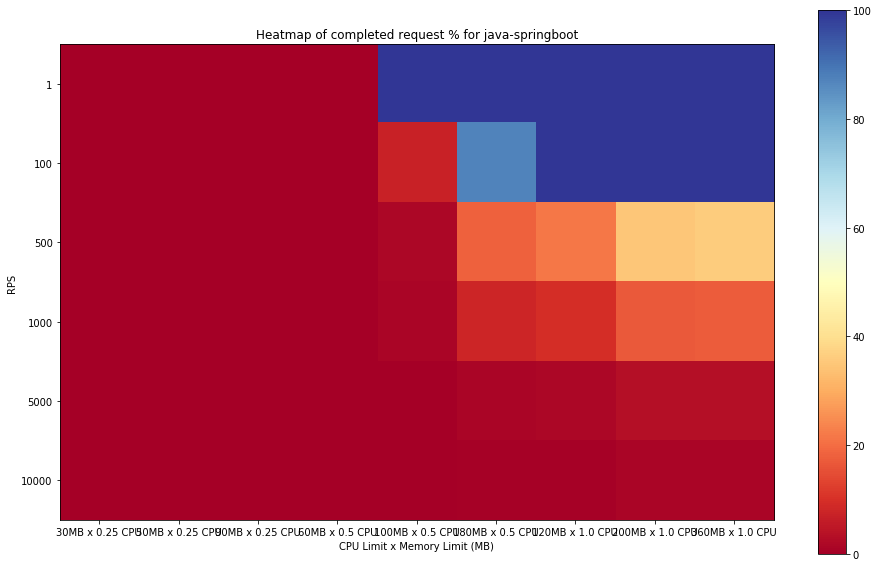

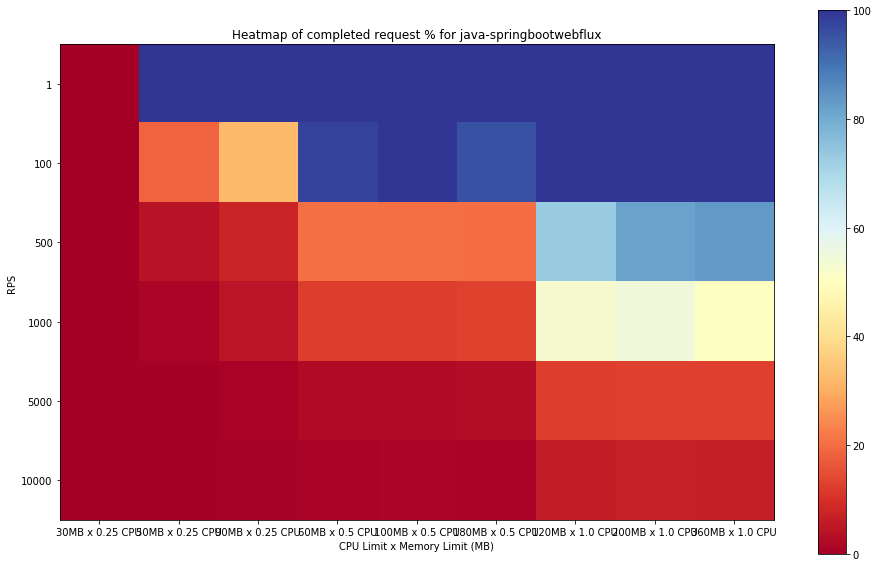

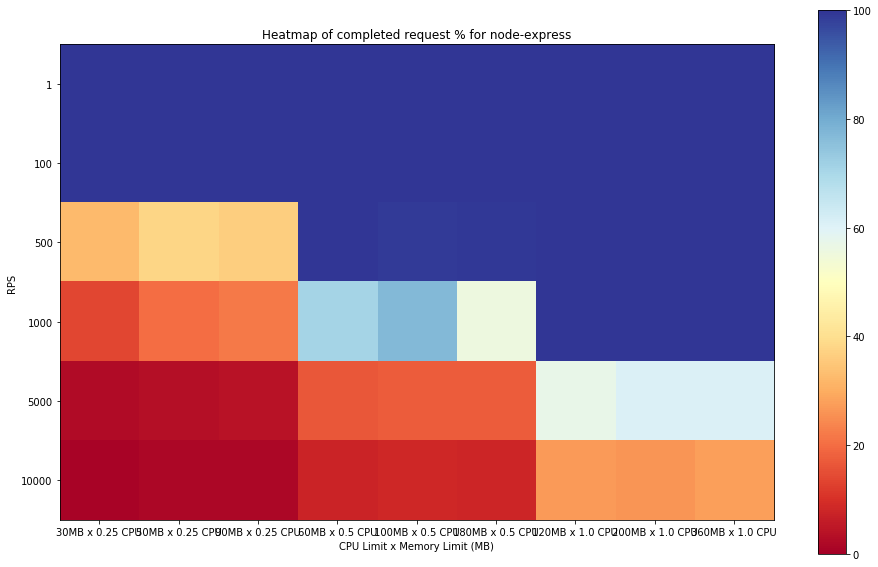

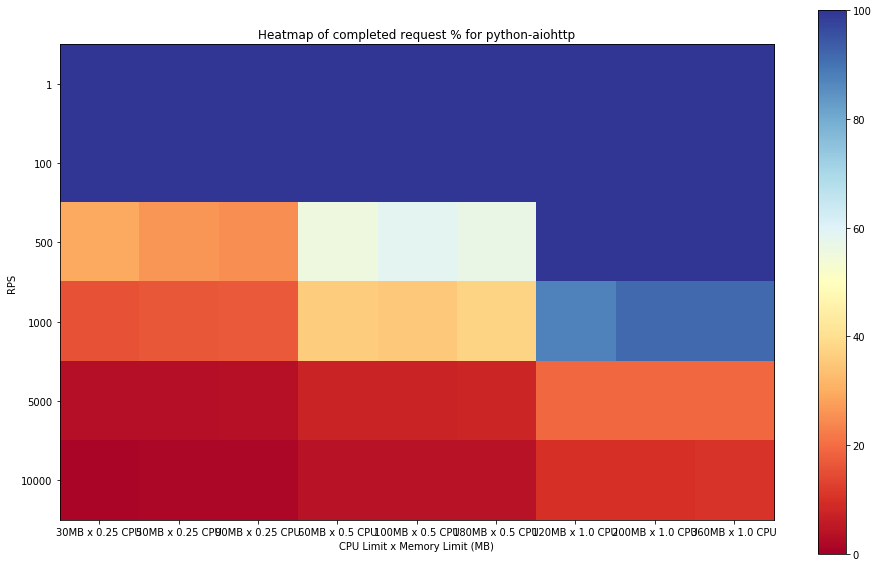

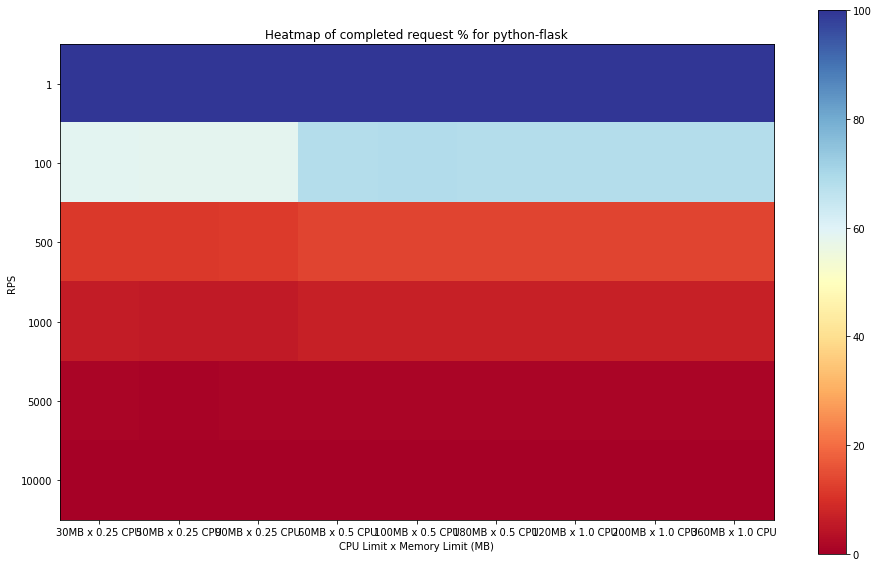

In [432]:
for scenario in scenarios:
    make_heatmap(unfiltered, scenario)